In [1]:
!pip install flask pyngrok ultralytics opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.4/715.4 kB 7.4 MB/s eta 0:00:00a 0:00:01m

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 5.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
# download model weights (model weights from charmain gdrive)
!gdown 1Nans6ofOqSJHHGgU4c8rYPfa7rN2Li4u

Downloading...
From: https://drive.google.com/uc?id=1Nans6ofOqSJHHGgU4c8rYPfa7rN2Li4u
To: /Users/darren/Documents/NTU/Y3S2/SC2079 - MDP/MDP/MDP28/cv/best.pt
100%|██████████████████████████████████████| 22.5M/22.5M [00:01<00:00, 13.2MB/s]


 * ngrok tunnel "https://49d8-155-69-194-63.ngrok-free.app" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit



0: 640x512 1 up, 117.9ms
Speed: 2.3ms preprocess, 117.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


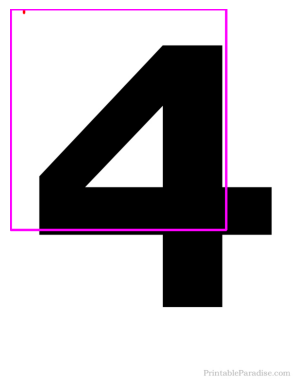

127.0.0.1 - - [21/Feb/2024 18:21:27] "POST /detect HTTP/1.1" 200 -


{'class_name': 'up', 'confidence': 0.6, 'bbox': [1, 0, 438, 448]}


In [4]:
import os

assert os.path.exists("best.pt"), "Model weights missing! Please upload"

import threading

from flask import Flask, request, jsonify
from pyngrok import ngrok

from ultralytics import YOLO
import cv2
import numpy as np
import math

import matplotlib.pyplot as plt

app = Flask(__name__)
port = "5000"

ngrok.set_auth_token("2c1j7chXBbEg6tM4gRq6dD9OLYB_6jB8fpkKRgSGepYagjEd3")

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# model
model = YOLO("best.pt")

# object classes
classNames = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'S', 'T',
              'U', 'V', 'W', 'X', 'Y', 'Z', 'bulls', 'down',
              'eight', 'five', 'four', 'left', 'nine', 'one',
              'right', 'seven', 'six', 'stop', 'three', 'two', 'up']
FONT = cv2.FONT_HERSHEY_SIMPLEX
COLOR = (255, 0, 0)

FONT_SCALE = 2e-3  # Adjust for larger font size in all images
THICKNESS_SCALE = 5e-3  # Adjust for larger thickness in all images

# Define Flask routes
@app.route("/")
def index():
    return "Hello from Colab!"

@app.route('/detect', methods=['POST'])
def detect():
    if 'image' not in request.files:
        return jsonify({"error": "Missing image file"}), 400

    file = request.files['image']
    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    # Convert the image file to a CV2 image
    filestr = file.read()
    npimg = np.frombuffer(filestr, np.uint8)
    img = cv2.imdecode(npimg, cv2.IMREAD_COLOR)

    # Perform object detection
    results = model(img, stream=True)
    detections = []

    # recolour
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            confidence = math.ceil((box.conf[0]*100))/100
            cls = int(box.cls[0])
            class_name = classNames[cls]

            detection = {
                "class_name": class_name,
                "confidence": confidence,
                "bbox": [x1, y1, x2, y2]
            }
            detections.append(detection)

            # add detected object label
            org = [x1, y1]
            height, width, _ = img.shape
            font_scale = min(width, height) * FONT_SCALE
            thickness = math.ceil(min(width, height) * THICKNESS_SCALE)
            img = cv2.putText(img, class_name, org, FONT, font_scale, COLOR, thickness)

            # add bounding box
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)

    # show image
    plt.imshow(img)
    plt.axis('off')
    plt.show()


    return jsonify(detections)

# Start the Flask server in a new thread
# threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()
app.run()

In [9]:
!pip install --upgrade python-dotenv



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
!ngrok authtoken <2c1j7chXBbEg6tM4gRq6dD9OLYB_6jB8fpkKRgSGepYagjEd3n>  # Replace <your_auth_token> with your ngrok authentication token
!ngrok kill ts_2cfjLmu3CBsaCZTiXQJQ1bxaIPL

zsh:1: parse error near `\n'
ngrok - tunnel local ports to public URLs and inspect traffic

USAGE:
  ngrok [command] [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backen

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok

In [1]:
!ngrok killall


ngrok - tunnel local ports to public URLs and inspect traffic

USAGE:
  ngrok [command] [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backen

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok with IP policy restrictions
